In [2]:
# Make sure we've got the latest fastbook version
! pip install -Uqq fastbook dotenv
import fastbook
fastbook.setup_book()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 12.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.1/124.1 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.9/246.9 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
# Connect to MongoDB and retrieve image URLs and metadata
from pymongo import MongoClient
import pandas as pd
from dotenv import load_dotenv
import os

# Load the dotenv file
load_dotenv()

# Grab the MONGO_URI from local or from Kaggle
mongo_uri = os.getenv('MONGO_URI')
if not mongo_uri:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    mongo_uri = user_secrets.get_secret("MONGO_URI")

# Connect to the MongoDB client
client = MongoClient(mongo_uri)
 
# Access the database and collection
db = client['test']  # Replace with your database name
collection = db['cameratrapmedias']  # Replace with your collection name
 
# Query the collection to retrieve records with image URLs, metadata, and the first index of 'relativePath'
data = list(collection.aggregate([
    {
        '$project': {
            '_id': 0,
            'publicURL': 1,
            'timestamp': 1,
            'relativePathSecond': { '$arrayElemAt': ['$relativePath', 1] }
        }
    },
    # { '$limit': 150 }
]))
 
# Convert the data to a pandas DataFrame for exploration
df = pd.DataFrame(data)

# Export the small array to a CSV file for preview
df.to_csv('small_array.csv', index=False)
 
# Display the first few rows of the DataFrame
print(df.head())

            timestamp  \
0 2024-01-27 13:33:15   
1 2024-01-24 18:56:50   
2 2024-01-24 19:01:54   
3 2024-01-24 19:03:05   
4 2024-01-24 19:04:19   

                                                                                                                   publicURL  \
0                   https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-01-30_prologis_02/DCIM/100MEDIA/SYFW0060.JPG   
1  https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-01-30_Learnin_platform_camera_test/DCIM/100MEDIA/SYFW0001.JPG   
2  https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-01-30_Learnin_platform_camera_test/DCIM/100MEDIA/SYFW0002.JPG   
3  https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-01-30_Learnin_platform_camera_test/DCIM/100MEDIA/SYFW0004.JPG   
4  https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-01-30_Learnin_platform_camera_test/DCIM/100MEDIA/SYFW0006.JPG   

                        relativePathSecond  
0                   2024-01-30_prol

Now that we have a connection to the MongoDB server and access to the URLs, let's use the `fastbook` library to simplify image handling and prepare for model inference.

In [4]:
# Preview 4 images from the publicURL column using fastbook
from fastbook import *
from fastai.vision.widgets import *

# Create a directory to save the images
path = Path('images')
path.mkdir(exist_ok=True)

# Download and display some images where at least an animal was found - ex rat
urls = df['publicURL'][44410:44420]
for i, url in enumerate(urls):
    # Download the image
    dest = path/f'image_{i}.jpg'
    download_url(url, dest)


In [5]:
# Create a list of all images that were downloaded
images = [PILImage.create(path/f'image_{i}.jpg') for i in range(10)]

In [6]:
# Check the images were loaded into PIL Images correctly
print(type(images[0]))

<class 'fastai.vision.core.PILImage'>


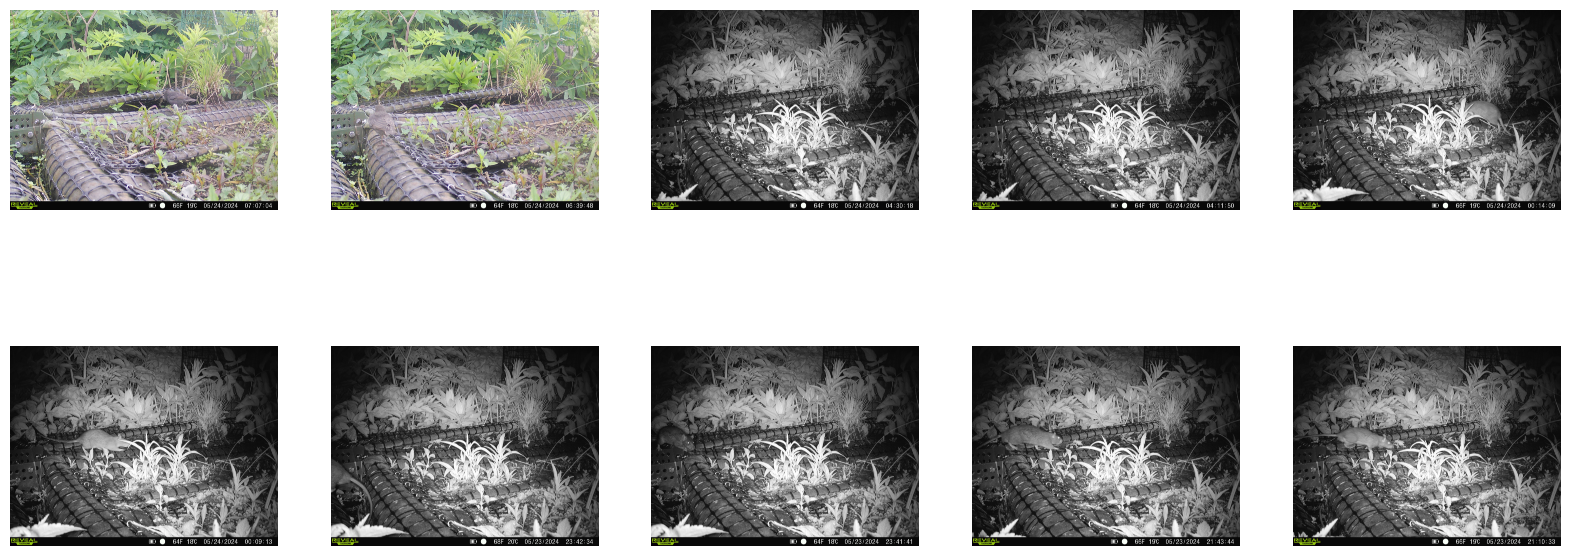

In [7]:
# Display the images using fastai utilities
%matplotlib inline
show_images(images, nrows=2, ncols=5, figsize=(20, 8))

We clearly have the ability to access the URLs and index through images - now there are two paths to take
1. Try using the full image Google speciesnet model (v4.0.1b) as is -
   - pre processing these images by vertical cropping top and bottom then scaling into right size (480x480px)


In [8]:
! pip install -Uqq speciesnet[notebooks]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 25.0 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 956.3/956.3 kB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.7/93.7 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 28.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.7/114.7 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━

In [9]:
from IPython.display import display
from IPython.display import JSON

from speciesnet import DEFAULT_MODEL
from speciesnet import draw_bboxes
from speciesnet import load_rgb_image
from speciesnet import SpeciesNet
from speciesnet import SUPPORTED_MODELS

In [10]:
def print_predictions(predictions_dict: dict) -> None:
    print("Predictions:")
    for prediction in predictions_dict["predictions"]:
        print(prediction["filepath"], "=>", prediction["prediction"])

In [11]:
print("Default SpeciesNet model:", DEFAULT_MODEL)
print("Supported SpeciesNet models:", SUPPORTED_MODELS)

Default SpeciesNet model: kaggle:google/speciesnet/pyTorch/v4.0.1a
Supported SpeciesNet models: ['kaggle:google/speciesnet/pyTorch/v4.0.1a', 'kaggle:google/speciesnet/pyTorch/v4.0.1b']


In [14]:
! python -m speciesnet.scripts.run_model --detector_only --folders "/kaggle/working/images" --predictions_json "/kaggle/working/detector_output.json"

Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/speciesnet/scripts/run_model.py", line 456, in <module>
    app.run(main)
  File "/usr/local/lib/python3.11/dist-packages/absl/app.py", line 308, in run
    _run_main(main, args)
  File "/usr/local/lib/python3.11/dist-packages/absl/app.py", line 254, in _run_main
    sys.exit(main(argv))
             ^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/speciesnet/scripts/run_model.py", line 378, in main
    model = SpeciesNet(
            ^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/speciesnet/multiprocessing.py", line 606, in __init__
    self.classifier = SpeciesNetClassifier(
                      ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/speciesnet/classifier.py", line 63, in __init__
    self.model_info = ModelInfo(model_name)
                     